# IFT6269 - Homework 3 - EM and Gaussian mixtures
**Due:**  Thursday, November 7, 2024

#### Name: Grégoire Barrette
#### Student ID: 20175180
#### Collaborators: None

## Introduction

The file `EMGaussian.train` contains samples of data $\{x_n\}_{n=1}^N$ where $x_n \in \mathbb{R}^2$, with one datapoint per row. The goal of this exercise is to implement the K-Means and EM algorithms using $K=4$ components/clusters.

### Tasks
0.   Get your own copy of this file via "File > Save a copy in Drive...",
1.   Fill your personal information and collaborators at the top of this assignment, and rename the notebook accordingly, e.g., `hw3_thomasBayes.ipynb`
2.   Read the instructions provided on each section and cell carefully,
4.   Implement the requested algorithms in section **Playground**
5.   In section **Model Comparison**, simply execute the cells (without changing the code) and type your answers to the questions in the provided text cells.
    
**Important**: You are allowed to collaborate with other students in both the math and coding parts of this assignment. However, the answers provided here must reflect your individual work. For that reason, you are not allowed to share this notebook, except for your submission to the TA for grading. **Don't forget to pin and save the version of the notebook you want to be graded on!**

In [259]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

X_train = np.loadtxt("hwk3data/EMGaussian.train")
X_test = np.loadtxt("hwk3data/EMGaussian.test")

## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the functions!

In [260]:
#@title Plotting code _(execute ▸ , but do not modify)_
# ---------------------------------------------------------------------------
#                       Code for plotting the results
#                      ! DO NOT MODIFY THESE FUNCTIONS !
# ---------------------------------------------------------------------------

from matplotlib.patches import Ellipse
def plot_ellipse(ax, mu, sigma, alpha=1, color="k"):
    evals, evecs = np.linalg.eigh(sigma)
    x, y = evecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))
    for factor in [1.5, 3]:
        w, h = factor * np.sqrt(evals)
        ellipse = Ellipse(mu, w, h, angle = theta, facecolor='none', edgecolor=color)
        ellipse.set_alpha(alpha)
        ax.add_artist(ellipse)

def show_kmeans(X_train, X_test, KM_centroids, KM_predictor):

    shapes = ['o', '*', 'v', '+']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b',
              '#e377c2', '#7f7f7f', '#bcbd22']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    for (ax, data, title) in [(ax1, X_train, 'Training Set'), (ax2, X_test, 'Test Set')]:
        pred_labels, obj = KM_predictor(data)
        print("K-Means Objective on " + title + ": ", obj)
        cs = [colors[int(_) % len(colors)] for _ in pred_labels]
        ax.scatter(data[:, 0], data[:, 1], alpha=0.5, c=cs)
        ax.scatter(KM_centroids[:, 0], KM_centroids[:, 1], marker='o', c='#d62728')
        ax.set_title(title)
        ax.set_xlim(-12, 12), ax.set_ylim(-12, 12)
        ax.set_aspect('equal')

    plt.show()
    print('\n')


def show_mog(X_train, X_test, MoG_pi, MoG_centroids, MoG_sigmas, MoG_predictor):

    shapes = ['o', '*', 'v', '+']
    colors = [[31, 119, 180], [255, 127, 14], [44, 160, 44], [148, 103, 189],
             [140, 86, 75], [227, 119, 194], [127, 127, 127], [188, 189, 34]]

    max_pi = np.max(MoG_pi)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    for (ax, data, title) in [(ax1, X_train, 'Training Set'), (ax2, X_test, 'Test Set')]:
        pred_labels, norm_llike = MoG_predictor(data)
        print("MoG Normalized Log-Likelihood " + title + ": ", norm_llike)
        cs = [colors[int(_) % len(colors)] + [0.5*255*MoG_pi[_]/max_pi] for _ in pred_labels]
        ax.scatter(data[:, 0], data[:, 1], c=np.array(cs)/255.)
        ax.scatter(MoG_centroids[:, 0], MoG_centroids[:, 1], marker='o', c='#d62728')
        ax.set_title(title)
        ax.set_xlim(-12, 12), ax.set_ylim(-12, 12)
        ax.set_aspect('equal')

        for _ in range(MoG_pi.shape[0]):
            plot_ellipse(ax, MoG_centroids[_, :], MoG_sigmas[_, :,:], alpha=MoG_pi[_]/max_pi, color='k')

    plt.show()
    print('\n')

In [261]:
def KMeans(X, K=1):
    """
    Estimates the parameters of a K-means model using training data X

        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of clusters to use

        Returns:
            centroids: [Kx2] matrix of estimated centroid locations
            KMeans_predictor: function taking a matrix inX and returning the
                predicted cluster number (starting from 0 to K-1) for each row
                of inX; and the normalized KMeans loss (i.e., divided by the
                number of rows of inX).

    """
    N = X.shape[0] # number of examples
    d = X.shape[1] # number of features per example
    tol = 1e-6 # tolerance criterion for convergence

    # initialize centroids randomly
    centroids = np.random.randn(K, d)

    objective = 1e5 
    old_loss = 1e5 

    # training loop
    while objective > tol:
        loss = 0 # running loss
        Z = np.zeros((N,K)) # cluster assignment Z[i,j]=1 means data X[i] is in cluster j

        # E step
        for i in range(N):

            distance = np.linalg.norm(X[i] - centroids, axis = 1)**2 # compute distance squared from point X[i] to all K centroids
            j = np.argmin(distance) # pick optimal cluster
            Z[i,j] = 1
            loss += distance[j] # running loss

        # M step

        centroids = np.matmul(Z.T, X) / np.sum(Z, axis = 0)[:, np.newaxis]
        objective = np.linalg.norm(old_loss - loss)
        old_loss = loss
    
    def KMeans_predictor(inX):
        """
        Use parameters from above to predict cluster for each row of inX

            Inputs:
                inX: [mx2] matrix of inputs

            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loss: [float] K-Means loss on inX, i.e. the *squared*
                    distance between each point and its associated cluster,
                    divided by the number of rows of inX.
        """

        m = inX.shape[0] # number of data points
        pred_labels = np.zeros(m) 
        loss = 0
        
        for i in range(m):
            
            distance = np.linalg.norm(inX[i] - centroids, axis = 1)**2 # compute squared distance between point X[i] and all final clusters
            j =  np.argmin(distance) # optimal cluster index

            pred_labels[i] = j # assign X[i] to cluster with smallest distance squared
            loss += distance[j]
              
        norm_loss = loss / m # normalized loss

        return pred_labels, norm_loss

    return centroids, KMeans_predictor

def GaussianMixture(X, K=1, use_full_cov=True):
    """
    Estimates the parameters of a Gaussian mixture model using training data X

    **Important:** The locations of the centroids must be initialized using your
    K-Means code! With this information, initialize the proportions and variances
    accordingly.

        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of mixture components to use
            use_full_cov: [bool] if True, estimate a full covariance for each
                mixture component. Else, we use a scaled identity for each
                component (in this case each component might have a
                different scaling of the identity: Sigma_i = sigma_i * I).

        Returns:
            pi: [K] vector of proportion of each class
            centroids: [Kx2] matrix of estimated centroid locations
            sigmas: [Kx2x2] tensor of estimated covariance matrices
            MoG_predictor: function taking a matrix inX and returning the
                predicted cluster number (starting from 0 to K-1) for each row
                of inX; and the normalized log-likelihood (i.e., ln(p(inX)) divided by the
                number of rows of inX).
    """

    # Initialization
    N = X.shape[0] # number of examples
    d = X.shape[1] # number of features per example

    centroids, _ = KMeans(X, K) # centroid means using KMeans
    pi = np.ones(K) / K
    tau = np.zeros((N, K))

    # covariance matrices
    if use_full_cov:
        # We use a full covariance for each class
        sigmas = np.concatenate(K * [np.eye(2)[np.newaxis, ...]], axis=0)
    else:
        # We use one scaled identity for each class
        sigmak2 = N*np.ones(K)  # These are the sigma^{2}_{k} for k = 1, ..., K
        sigmas = np.concatenate([sigmak2[i] * np.eye(2)[np.newaxis, ...] for i in range(K)], axis=0)
        # Careful! We expect to return the covariance matrices. Don't mix these up!

    tol = 1e-9
    objective = 1e5
    old_loss = 1e5

    # convergence loop
    while objective > tol:
        
        # E step

        # computing tau
        for i in range(N):
            log_tau_row = np.zeros(K)  

            for j in range(K):
                mahalanobis_distance = (X[i] - centroids[j]).T @ np.linalg.inv(sigmas[j]) @ (X[i] - centroids[j])
                log_tau_row[j] = np.log(pi[j]) - 0.5 * mahalanobis_distance - (d / 2) * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(sigmas[j]))
            
            tau[i, :] = np.exp(log_tau_row) 
            tau[i, :] /= np.sum(tau[i, :])  # Normalize tau

        # M step

        # update pi
        pi = np.sum(tau, axis = 0) / N

        # update centroids
        for j in range(K):
            centroids[j] = np.sum(tau[:, j][:, np.newaxis] * X, axis = 0) / np.sum(tau[:,j])
        
        # update covariance
        if use_full_cov == True:
            # update full covariance matrices
            for j in range(K):
                temp = np.zeros((d,d))
                for i in range (N):
                    distance = X[i] - centroids[j]
                    temp += tau[i,j] * np.outer(distance, distance) 

                sigmas[j] = temp / np.sum(tau[:,j]) 
        else:
            # update spherical covariance matrices
            for j in range(K):
                temp = 0
                for i in range(N):
                    distance = X[i] - centroids[j]
                    temp += tau[i, j] * np.dot(distance, distance)
                sigma_j = temp / (d*np.sum(tau[:, j]))  
                sigmas[j] = sigma_j * np.eye(d)  # Assign the spherical covariance matrix
        
        log_likelihood = 0
        for i in range(N):
            point_log_likelihood = 0
            for j in range(K):
                mahalanobis_distance = (X[i] - centroids[j]).T @ np.linalg.inv(sigmas[j]) @ (X[i] - centroids[j])
                point_log_likelihood += pi[j] * np.exp(-0.5 * mahalanobis_distance) / (np.sqrt((2 * np.pi)**d * np.linalg.det(sigmas[j])))
            log_likelihood += np.log(point_log_likelihood)

        # Check for convergence based on change in log-likelihood
        objective = np.abs(log_likelihood - old_loss)
        
        old_loss = log_likelihood

    def MoG_predictor(inX):
        """
        # Use parameters from above to predict cluster for each row of inX

            Inputs:
                inX: [mx2] matrix of inputs

            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loglike: [float] the log-likelihood of inX, i.e. ln(p(inX)),
                    divided by the number of rows of inX.

        """
        m = inX.shape[0] # number of examples

        # computing tau for the given data sets using optimal parameters obtained above
        tau = np.zeros((N, K))

        for i in range(m):
            log_tau_row = np.zeros(K)

            for j in range(K):
                # Log probability for component j
                mahalanobis_distance = (inX[i] - centroids[j]).T @ np.linalg.inv(sigmas[j]) @ (inX[i] - centroids[j])
                log_tau_row[j] = np.log(pi[j]) - 0.5 * mahalanobis_distance - (d / 2) * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(sigmas[j]))

            tau[i, :] = np.exp(log_tau_row)
            tau[i, :] /= np.sum(tau[i, :])  # normalization
        
        # use tau to predict labels
        pred_labels = np.argmax(tau, axis =1) 
        
        # compute the log likelihood
        log_likelihood = 0
        for i in range(N):
            point_log_likelihood = 0

            for j in range(K):
                mahalanobis_distance = (inX[i] - centroids[j]).T @ np.linalg.inv(sigmas[j]) @ (inX[i] - centroids[j])
                point_log_likelihood += pi[j] * np.exp(-0.5 * mahalanobis_distance) / (np.sqrt((2 * np.pi)**d * np.linalg.det(sigmas[j])))
                
            log_likelihood += np.log(point_log_likelihood)

        norm_loglike = log_likelihood / m # normalized loglikelihood
        return pred_labels, norm_loglike

    return pi, centroids, sigmas, MoG_predictor

## Model Comparison

In this section **DO NOT** change the code in any of the cells. Simply answer the questions in the corresponding text cells after having executed your implementation. If you have respected the signature of the functions above in terms of inputs and outputs, your code should run.

### K-Means


K-Means Objective on Training Set:  6.48118604949102
K-Means Objective on Test Set:  6.146732419783495


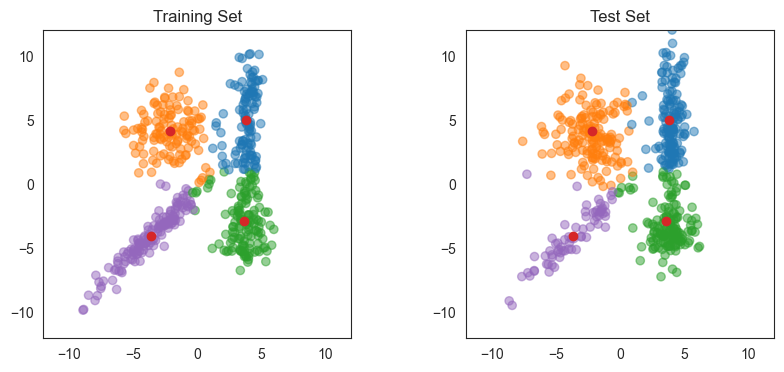



K-Means Objective on Training Set:  6.476276886129602
K-Means Objective on Test Set:  6.205199848006527


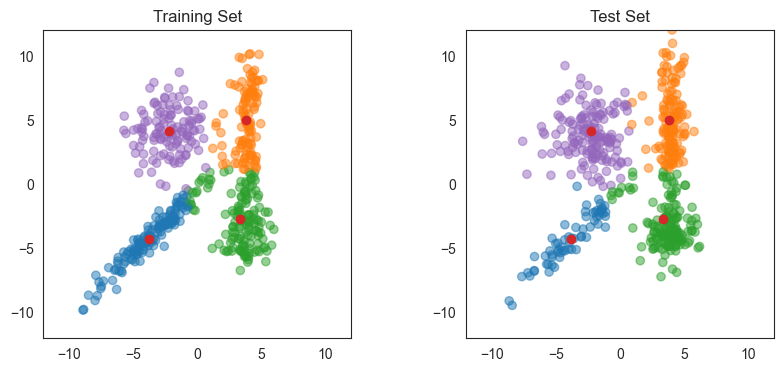



K-Means Objective on Training Set:  6.48118604949102
K-Means Objective on Test Set:  6.146732419783495


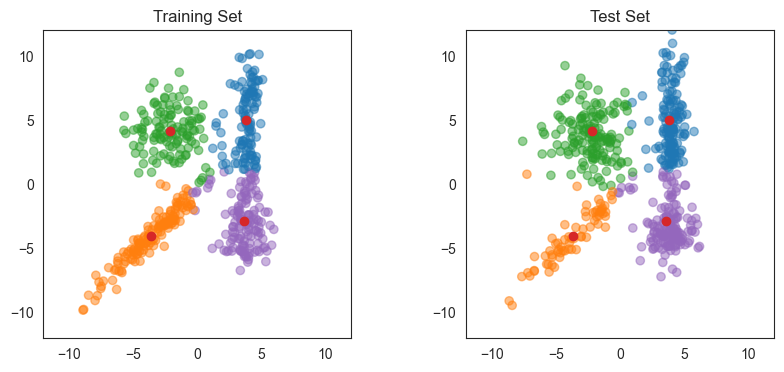

In [262]:
for run in range(3):
    KM_centroids, KM_predictor = KMeans(X_train, K=4)
    show_kmeans(X_train, X_test, KM_centroids, KM_predictor)

We have trained your implementation of the K-Means algorithm using `X_train` for 3 different initializations.

**Question:** Briefly compare the results above in terms of the location of the centers and the K-means training objective (at convergence) across runs with different initializations. What conclusions can you draw from this?

**Answer:** All runs have almost the same training objective, which is a measure of the mean squared distance between data points and their assigned cluster. This means that cluster centers converged to almost the same values for each training run. That's what we can see on the graphs: we can't say that the location of the clusters are different from run to run. I can conclude that the algorithm converges very well for this data.

One thing of note, the objective is smaller on the test set! This is bizarre as the parameters were optimized to fit the training data. Maybe the data in the test set is more clustered according to a spherical distance measure (Euclidian distance, i.e. the objective) so that the algorithm performs better on this data.

### EM for Gaussian mixture models

Scaled identity covariance matrices
MoG Normalized Log-Likelihood Training Set:  -5.27913851249634
MoG Normalized Log-Likelihood Test Set:  -5.2292074323732685


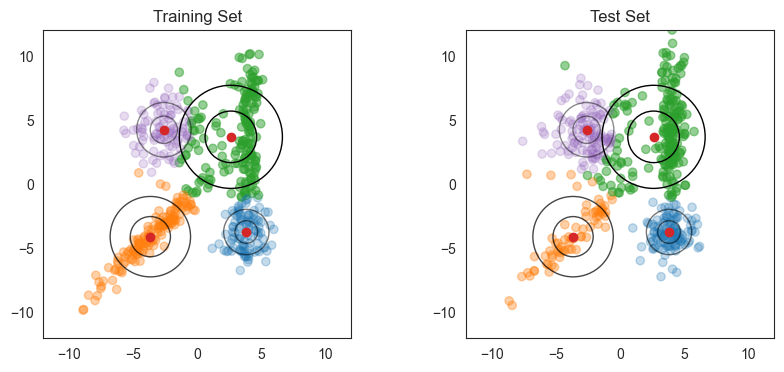




Full covariance matrices
MoG Normalized Log-Likelihood Training Set:  -4.6554313498472295
MoG Normalized Log-Likelihood Test Set:  -4.817956441371771


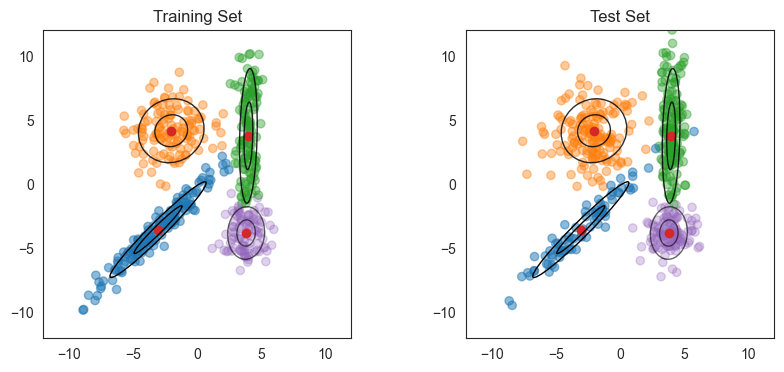

In [263]:
print('Scaled identity covariance matrices')
MoG1 = GaussianMixture(X_train, K=4, use_full_cov=False)
show_mog(X_train, X_test, MoG1[0], MoG1[1], MoG1[2], MoG1[3])

print('\nFull covariance matrices')
MoG2 = GaussianMixture(X_train, K=4, use_full_cov=True)
show_mog(X_train, X_test, MoG2[0], MoG2[1], MoG2[2], MoG2[3])

We have trained your implementation of the EM algorithm for a Gaussian mixture model using `X_train`. The plots show the behavior on the training and testing (left and right) sets when using scaled diagonal or full covariance matrices (top and bottom), respectively.

**Question:** Briefly compare the results above in terms of the location of the centers and the normalized log-likelihood between the training and test set. What conclusions can you draw from this?

**Answer:** For both the spherical and the full covariances, the normalized log-likelihood is smaller (more negative) on the test set and hence fits less the data than on the training set. In terms of the location of the centers, well they are the same for both sets, so it makes sense that the normalized log-likelihood is bigger (the parameters are better fit) on the training set, because they were optimized to fit this set.

I'm not super happy with the results of spherical covariance however, since it looks like K-Means outperforms EM in this case just by looking at the plots. There may be something wrong with my implementation. There are also weird things happening on the test set with full covariances: there are data points in the upper right quadrant that were assigned to the cluster in the lower left quadrant that might belong the cluster in the upper right quadrant.

### Bonus
**Question:** From your observations in the K-Means and EM sections, is there any relation one can stablish between these two methods? If so, how do the plots above reflect this?  

**Answer:** I think we can establish a link between K-Means and EM with spherical covariances. Indeed, the objective in K-Means is to minimize the square of the distance between the data points and the centroid of the assigned cluster. This distance is just
\begin{equation}
l^2 = \sum_{i=1}^d x_i^2,
\end{equation}
which is the equation of a sphere in $d$ dimensions. We can see in the K-Mean and spherical EM plots that the algorithms tend to cluster points together in a spherical fashion, while the EM with a full covariance is able to capture clusters that are more elliptical.